## Coin grading research notes

A coin's grade is generally determined by five criteria: strike, preservation, luster, color, and attractiveness. In this research we will try to propose a quantitative model for grading automation of modern coins by focusing on luster and color.

## Single coin analysis

Below is an example of two American Silver Eagle 2018 coins graded 69 and 70. 

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

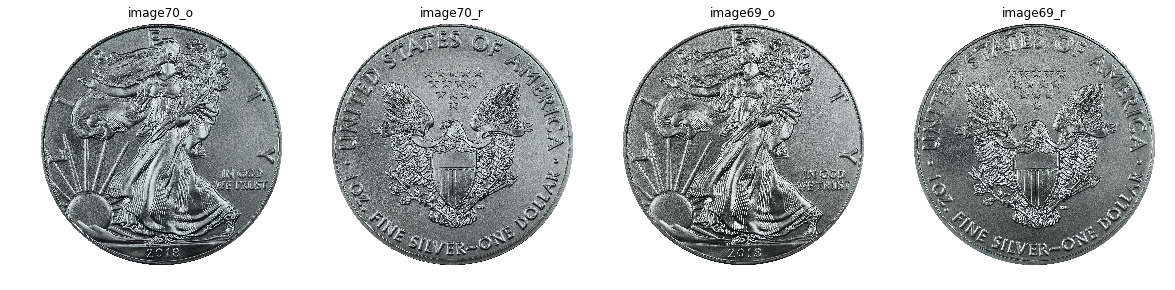

In [2]:
file69_o = "images/ASE_69/69_MS_1_o.JPG"
file70_o = "images/ASE_70/70_MS_1_o.JPG"

file69_r = "images/ASE_69/69_MS_1_r.JPG"
file70_r = "images/ASE_70/70_MS_1_r.JPG"

image69_o = cv2.imread(file69_o)
image70_o = cv2.imread(file70_o)

image69_r = cv2.imread(file69_r)
image70_r = cv2.imread(file70_r)

f = plt.figure(figsize=(20, 20))

f.add_subplot(141).axis('off')
plt.imshow(image70_o)
plt.title('image70_o')

f.add_subplot(142).axis('off')
plt.imshow(image70_r)
plt.title('image70_r')

f.add_subplot(143).axis('off')
plt.imshow(image69_o)
plt.title('image69_o')

f.add_subplot(144).axis('off')
plt.imshow(image69_r)
plt.title('image69_r')

plt.show()


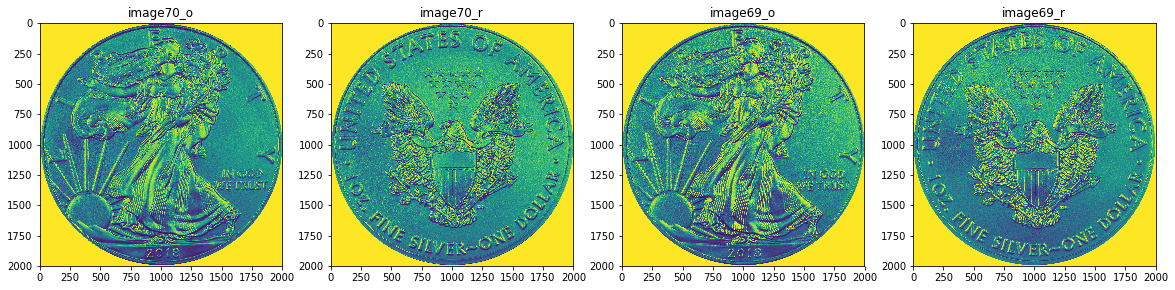

In [3]:
image69_o = cv2.cvtColor(image69_o, cv2.COLOR_BGR2GRAY)
image70_o = cv2.cvtColor(image70_o, cv2.COLOR_BGR2GRAY)
image69_r = cv2.cvtColor(image69_r, cv2.COLOR_BGR2GRAY)
image70_r = cv2.cvtColor(image70_r, cv2.COLOR_BGR2GRAY)

f = plt.figure(figsize=(20, 20))
f.add_subplot(141)
plt.imshow(image70_o)
plt.title('image70_o')

f.add_subplot(142)
plt.imshow(image70_r)
plt.title('image70_r')

f.add_subplot(143)
plt.imshow(image69_o)
plt.title('image69_o')

f.add_subplot(144)
plt.imshow(image69_r)
plt.title('image69_r')

plt.show()

### Histograms
Let's generate the color histograms for both the obverse and the reverse sides of two coins graded 69 and 70 respectively and see what we can deduct from the results.

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

mask = np.zeros(image69_o.shape[:2], dtype="uint8")
# original images are 2000x2000, so the mask radius will be 1000
(cX, cY) = (image69_o.shape[1] // 2, image69_o.shape[0] // 2)
cv2.circle(mask, (cX, cY), 1000, 255, -1) 

#image69_o_masked = cv2.bitwise_and(image69_o, image69_o, mask = mask)
#image70_o_masked = cv2.bitwise_and(image70_o, image70_o, mask = mask)

#image69_r_masked = cv2.bitwise_and(image69_r, image69_r, mask = mask)
#image70_r_masked = cv2.bitwise_and(image70_r, image70_r, mask = mask)

hist69_o = cv2.calcHist([image69_o], channels = [0], mask = mask, histSize = [256], ranges=[0, 255])
hist70_o = cv2.calcHist([image70_o], channels = [0], mask = mask, histSize = [256], ranges=[0, 255])

hist69_r = cv2.calcHist([image69_r], channels = [0], mask = mask, histSize = [256], ranges=[0, 255])
hist70_r = cv2.calcHist([image70_r], channels = [0], mask = mask, histSize = [256], ranges=[0, 255])

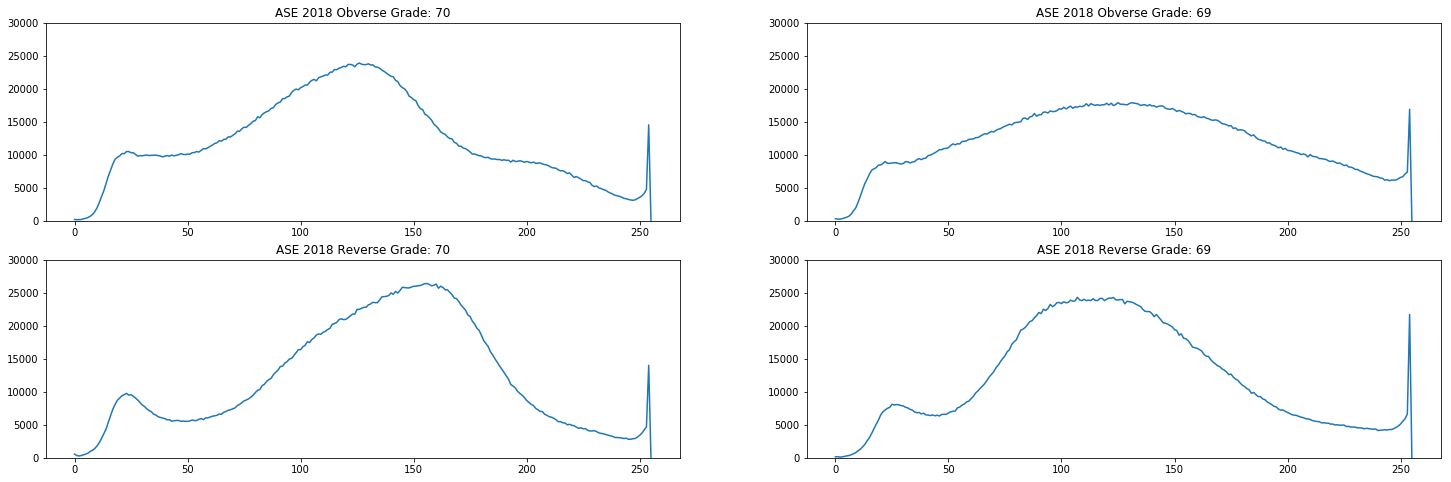

In [5]:
f = plt.figure(figsize=(25, 8))
yLim = 30000

f.add_subplot(2,2,1)
plt.title("ASE 2018 Obverse Grade: 70")
plt.plot(hist70_o)
plt.ylim([0, yLim])

f.add_subplot(2,2,2)
plt.title("ASE 2018 Obverse Grade: 69")
plt.ylim([0, yLim])
plt.plot(hist69_o)

f.add_subplot(2,2,3)
plt.title("ASE 2018 Reverse Grade: 70")
plt.plot(hist70_r)
plt.ylim([0, yLim])

f.add_subplot(2,2,4)
plt.title("ASE 2018 Reverse Grade: 69")
plt.ylim([0, yLim])
plt.plot(hist69_r)

plt.show()

### Observations:

<ul>
    <li> Effectively, we have 3 major peaks around low, medium and high pixel intensities. Let's split them as follows:<ul>
    <li>`dark`   - where 0 < x < 50
    <li>`medium` - where 50 < x < 200
    <li>`light`  -  where 200 < x < 256
</ul>
    <li> Both histograms show the same pattern with two strongly pronounced maximums and a rugged tail around the bucket 250 (light colors)
    <li> Absolute max values peak between buckets 100 and 150 
    <li> <b>Absolute max for the grade 70 is much higher than that of the grade 69!</b>
    <li> Both plots show rugged behavior around bucket 250 (light colors) with <b>grade 69 having much higher variance *</b>
    <li> The local maxima of light colors (240 < bins < 250) is higher than the local maxima of the dark colors (0 < bins < 25)
</ul>

Before we proceed any further, let's see if we can figure out what part of the coin each peak is responsible for. We will achieve this by thresholding the images around the given intensity values. This excersize will help in defining a quantitative model for moder coin grading.

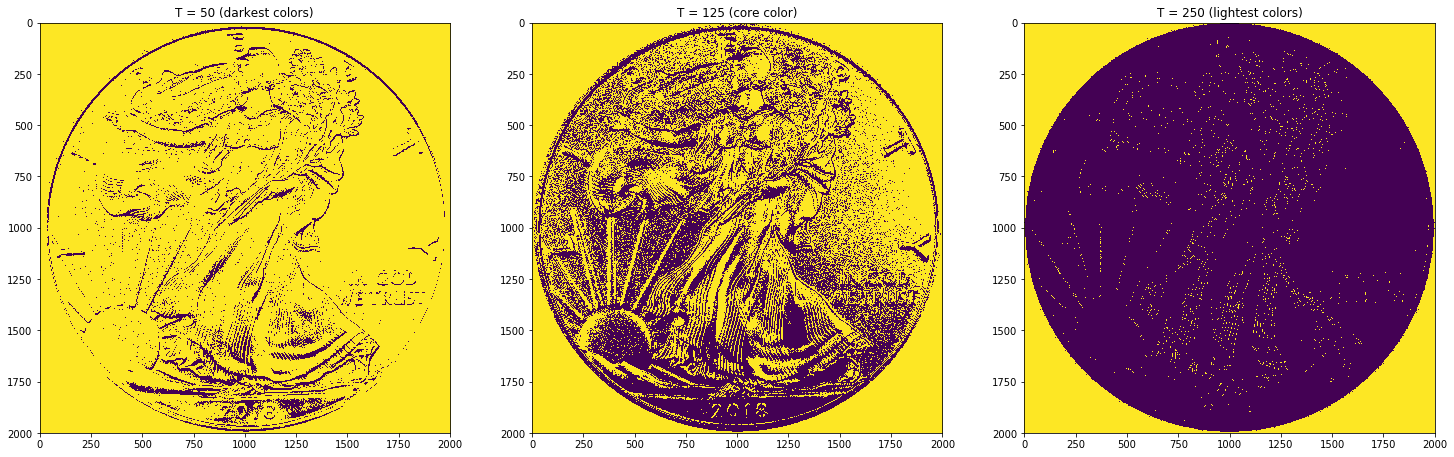

In [6]:
_, image69_o_thresh_1 = cv2.threshold(image69_o, 50, 255, cv2.THRESH_BINARY)
_, image69_o_thresh_2 = cv2.threshold(image69_o, 125, 255, cv2.THRESH_BINARY)
_, image69_o_thresh_3 = cv2.threshold(image69_o, 250, 255, cv2.THRESH_BINARY)

f = plt.figure(figsize=(25, 25))

f.add_subplot(1,3,1)
plt.imshow(image69_o_thresh_1)
plt.title('T = 50 (darkest colors)')

f.add_subplot(1,3,2)
plt.imshow(image69_o_thresh_2)
plt.title('T = 125 (core color)')

f.add_subplot(1,3,3)
plt.imshow(image69_o_thresh_3)
plt.title('T = 250 (lightest colors)')

plt.show()

### Observations
As we see, the darkest colors (0 < x < 50) are the result of the shadows cast by the _imprint_. The medium colors are the core color of the coin. And, finally, the lightest colors are the convex (bulge) areas reflecting the light.

## Multiple coin histograms

We have 5 grade 69 and 5 grade 70 coins. Let's generate the remaining histograms and see if the above mentioned patterns hold true for the remaining of the coins.

In [1]:
import cv2
from matplotlib import pyplot as plt

In [2]:
histograms = {}
for i in range(1, 6):
    
    file69_o = "images/ASE_69/69_MS_" + str(i) + "_o.JPG"
    file69_r = "images/ASE_69/69_MS_" + str(i) + "_r.JPG"
    file70_o = "images/ASE_70/70_MS_" + str(i) + "_o.JPG"
    file70_r = "images/ASE_70/70_MS_" + str(i) + "_r.JPG"
    
    image69_o = cv2.imread(file69_o)
    image69_r = cv2.imread(file69_r)
    image70_o = cv2.imread(file70_o)
    image70_r = cv2.imread(file70_r)
    
    image69_o_gray = cv2.cvtColor(image69_o, cv2.COLOR_BGR2GRAY)
    image69_r_gray = cv2.cvtColor(image69_r, cv2.COLOR_BGR2GRAY)
    image70_o_gray = cv2.cvtColor(image70_o, cv2.COLOR_BGR2GRAY)
    image70_r_gray = cv2.cvtColor(image70_r, cv2.COLOR_BGR2GRAY)
    
    hist69_o = cv2.calcHist([image69_o_gray], channels = [0], mask = None, histSize = [256], ranges=[0, 255])
    hist69_r = cv2.calcHist([image69_r_gray], channels = [0], mask = None, histSize = [256], ranges=[0, 255])
    hist70_o = cv2.calcHist([image70_o_gray], channels = [0], mask = None, histSize = [256], ranges=[0, 255])    
    hist70_r = cv2.calcHist([image70_r_gray], channels = [0], mask = None, histSize = [256], ranges=[0, 255])

    histograms[file69_o] = hist69_o
    histograms[file69_r] = hist69_r
    histograms[file70_o] = hist70_o
    histograms[file70_r] = hist70_r

_The reson I am using size and range up to 255 is to omit the pure white color which dominates the original picture (the area around the coin)_

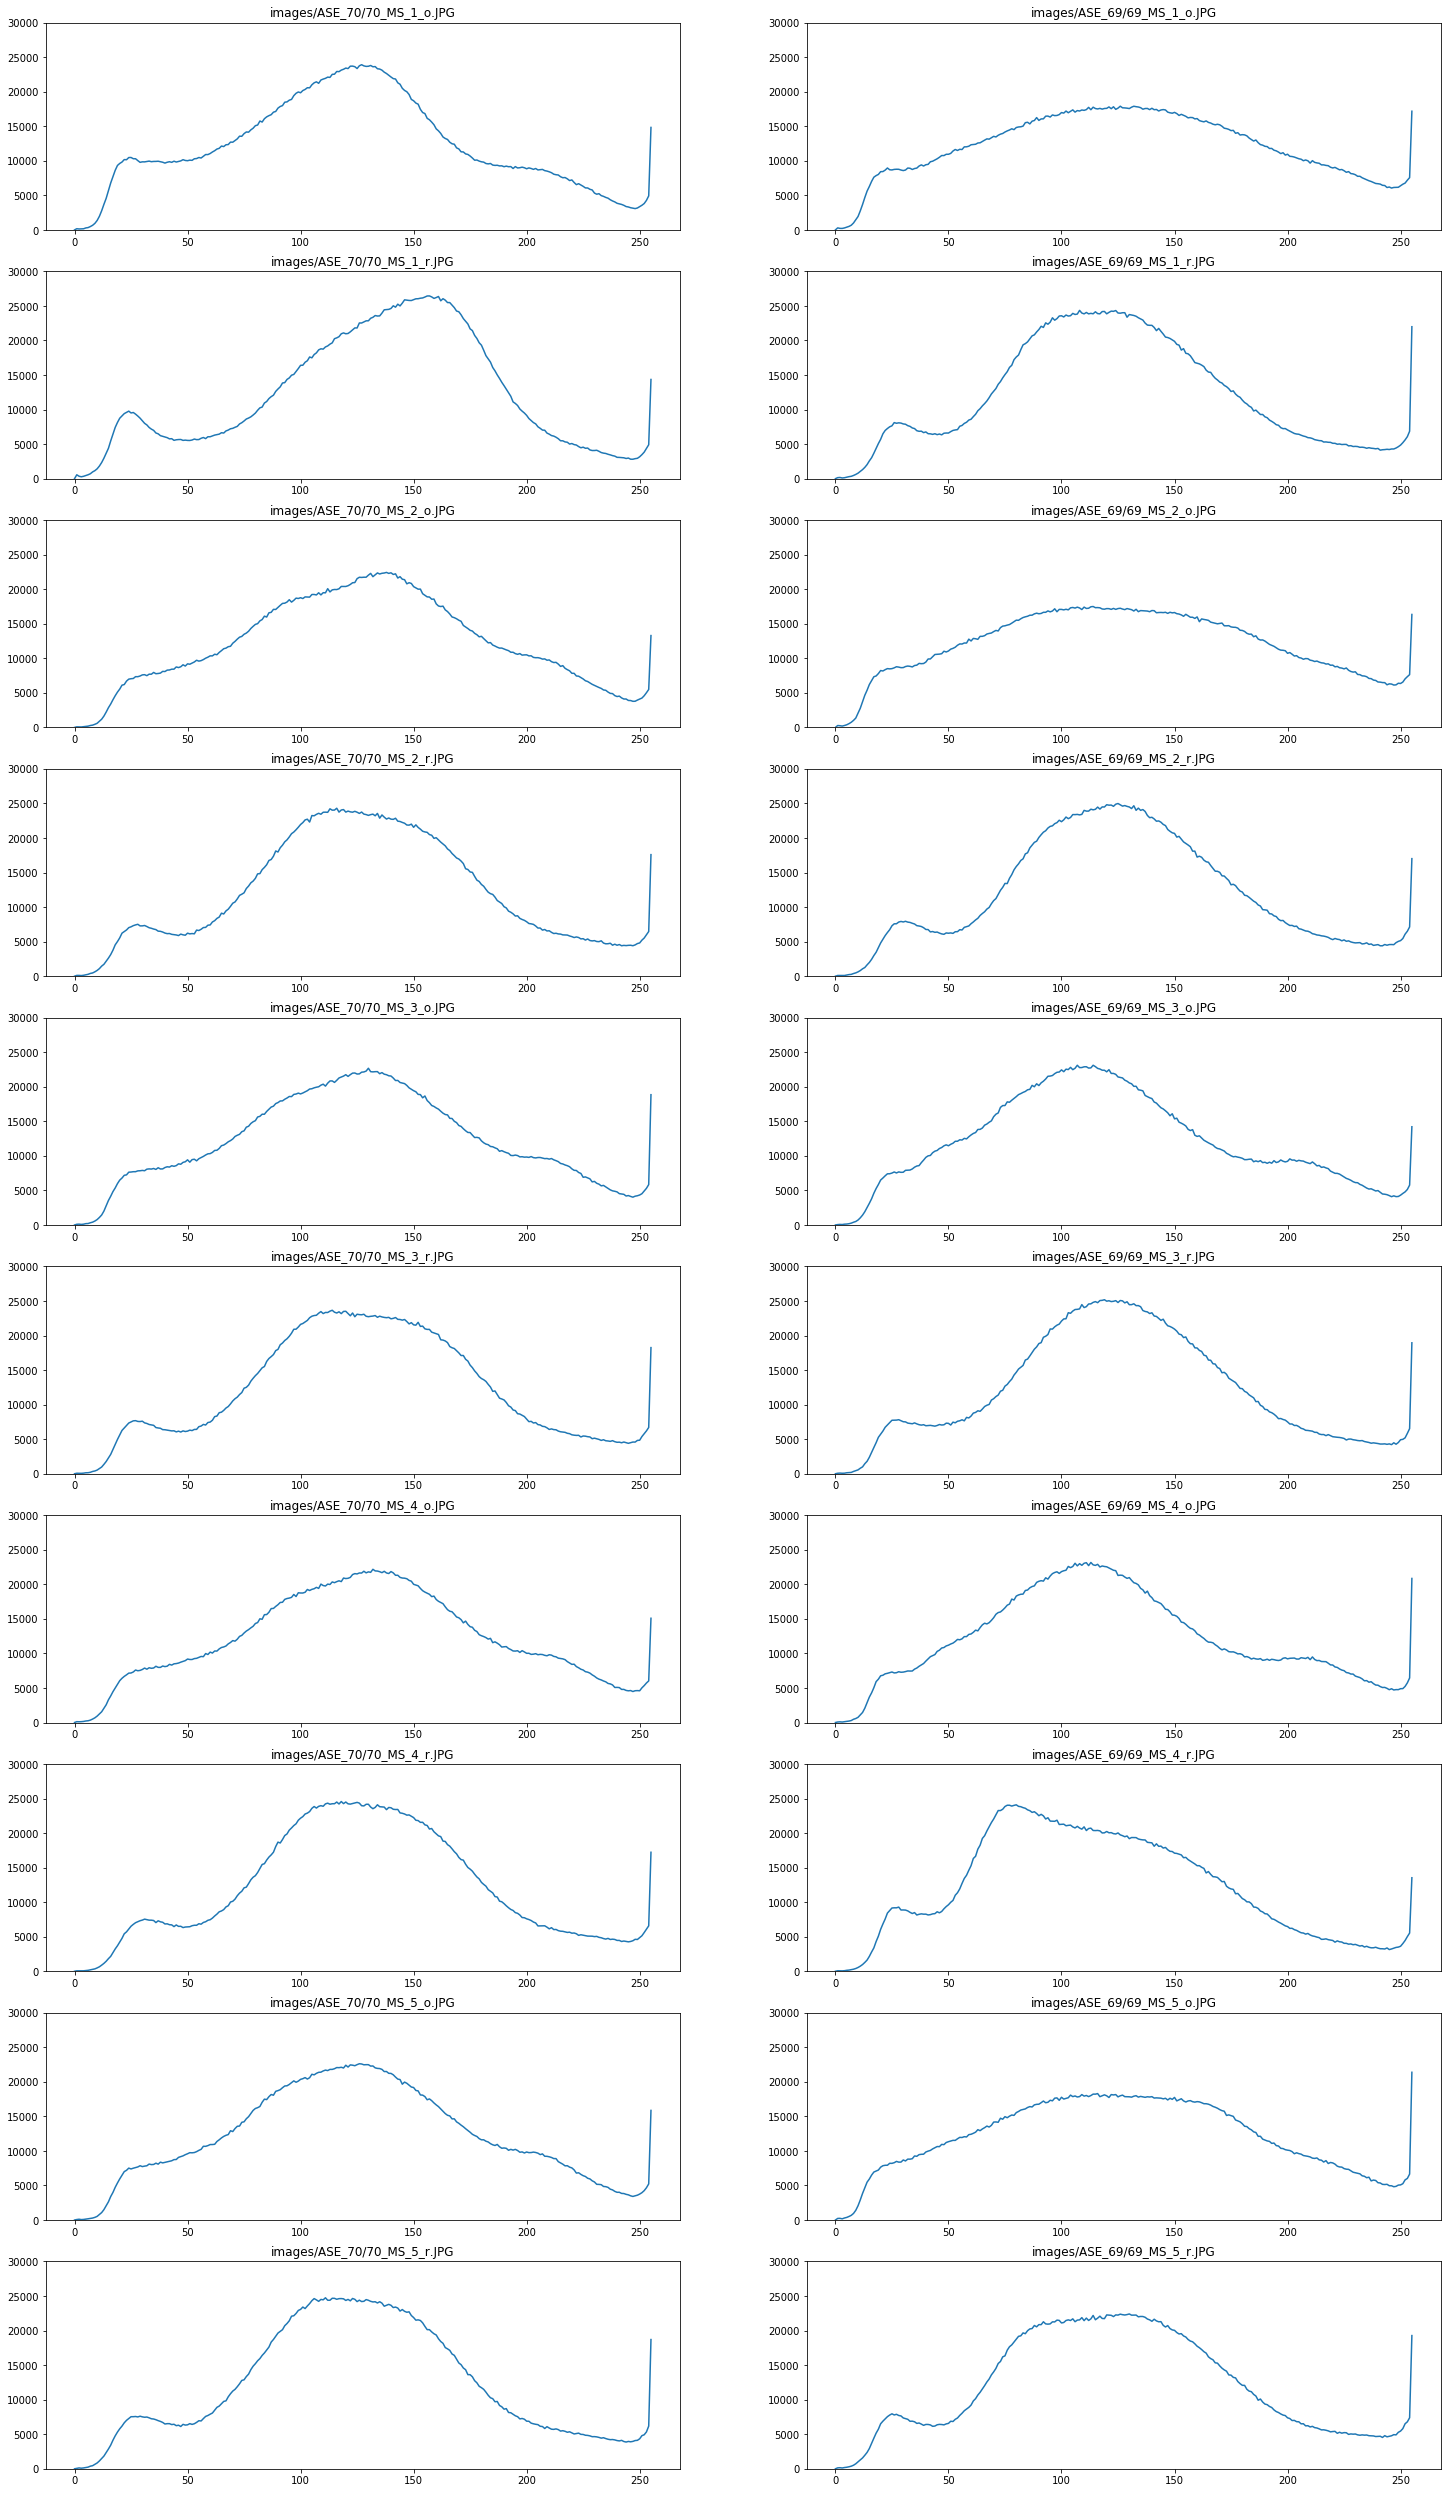

In [3]:
f = plt.figure(figsize=(25, 45))
yLim = 30000
j = 1
for i in range(1, 6):
    
    fileNames = []
    file69_o = "images/ASE_69/69_MS_" + str(i) + "_o.JPG"
    file69_r = "images/ASE_69/69_MS_" + str(i) + "_r.JPG"
    file70_o = "images/ASE_70/70_MS_" + str(i) + "_o.JPG"
    file70_r = "images/ASE_70/70_MS_" + str(i) + "_r.JPG"
        
    f.add_subplot(10,2,j)
    plt.title(file70_o)
    plt.ylim([0, yLim])
    plt.plot(histograms[file70_o])
    j += 1
    
    f.add_subplot(10,2,j)
    plt.title(file69_o)
    plt.ylim([0, yLim])
    plt.plot(histograms[file69_o])
    j += 1
    
    f.add_subplot(10,2,j)
    plt.title(file70_r)
    plt.ylim([0, yLim])
    plt.plot(histograms[file70_r])
    j += 1
    
    f.add_subplot(10,2,j)
    plt.title(file69_r)
    plt.ylim([0, yLim])
    plt.plot(histograms[file69_r])
    j += 1
    
plt.show() 

We do see that for the most part 
1. The middle maximum for Grade 70 coins peaks at higher numbers than that of the Grade 69
2. Variance of the light color portion is higher in 69s
3. Light color peaks are higher than the dark color for 69s


So far, so good. Now let's stack up the histograms to get a better picture of how the 69s (green) differ from 70s (blue). 

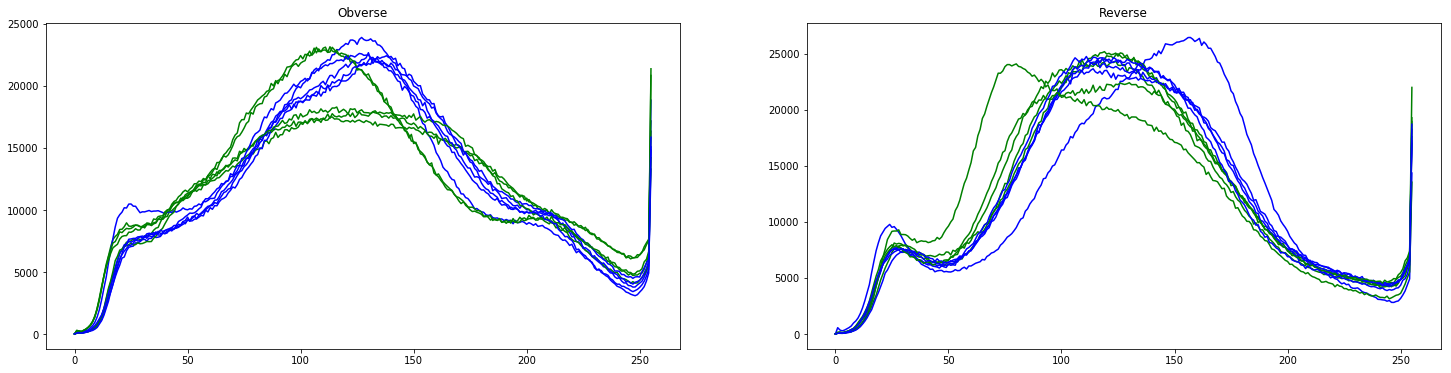

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,6))
for i in range(1, 6):
    
    file69_o = "images/ASE_69/69_MS_" + str(i) + "_o.JPG"
    file69_r = "images/ASE_69/69_MS_" + str(i) + "_r.JPG"
    file70_o = "images/ASE_70/70_MS_" + str(i) + "_o.JPG"
    file70_r = "images/ASE_70/70_MS_" + str(i) + "_r.JPG"
        
    fig.add_subplot(121)
    plt.title('Obverse')
    plt.plot(histograms[file69_o], 'g')
    plt.plot(histograms[file70_o], 'b')
    
    fig.add_subplot(122)
    plt.title('Reverse')
    plt.plot(histograms[file69_r], 'g')
    plt.plot(histograms[file70_r], 'b')

plt.show()

### Observations
From the above two plots we can say that 
- The grade 70 coins have less dark and light colors, however the main color is more saturated than that of the grade 69s.
- On both obverse and reverse sides around 50 we have a 100% separation with 69s having higher values (i.e. 69s have more dark colors than 70s)
- The reverse side data looks less separable and no deduction can be made at this point with the limited data at hand. 

### Tabular data showing integral values
So far we worked with grayscale (i.e. single channel) images. 

TB

## Color based analysis

The coins are grayscale in nature, however, certain imperfections such as rust can show up as yellow/brown (see the example below). Let's generate the histograms for all channels and see if it tells us anything. 

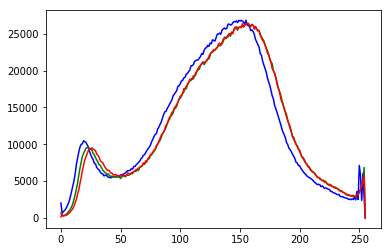

In [34]:
import cv2
from matplotlib import pyplot as plt

file69_o = "images/ASE_69/69_MS_1_o.JPG"
file70_o = "images/ASE_70/70_MS_1_o.JPG"
file69_r = "images/ASE_69/69_MS_1_r.JPG"
file70_r = "images/ASE_70/70_MS_1_r.JPG"

image69_o = cv2.imread(file69_o)
image70_o = cv2.imread(file70_o)
image69_r = cv2.imread(file69_r)
image70_r = cv2.imread(file70_r)

#image70_r = cv2.cvtColor(image70_r, cv2.COLOR_BGR2RGB)

for i, col in enumerate(['b', 'g', 'r']):
    hist = cv2.calcHist([image70_r], [i], None, [256], [0, 255])
    plt.plot(hist, color = col)

plt.show()

Since gray is the dominant color (i.e. it is a mix of RGB), separating the color channels produces no usefull data as all three channels _behave_ the same. No observations can be made from this.

Ideas for future: _- Use edge detection to separate the backgroud from the imprint. Analyse the background for noise_

## HSV Space based analysis: 

Now let's analyse the same images in the HSV color space. The HSV (Hue, Saturation, Value) color space describes color in a way that is better perceived by humans:

<ul>
<li>Hue: The dominant color as perceived by an observer (raw color). I.e. the actual color. 
<li>Saturation: The amount of white light mixed with a Hue (how concentrated the color is). Indicates the amount of grey in a color. A saturation value of 0 indicates mostly grey while 100% luminosity (or L = 255) is white.
<li>Value (brightness): The chromatic notion of intensity (i.e. the lower the value the more similar to black, the higher the value, the more similar to the color itself). A.k.a brightness - refers to how much white (or black) is mixed in the color.
</ul>

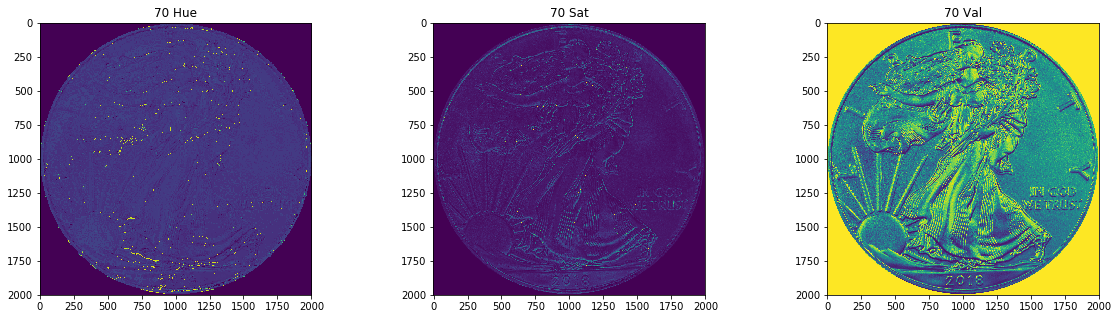

In [22]:
import cv2
from matplotlib import pyplot as plt

file70_o = "images/ASE_70/70_MS_1_o.JPG"
image70_o = cv2.imread(file70_o)
hsv_image = cv2.cvtColor(image70_o, cv2.COLOR_BGR2HSV)
hue, sat, val = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]

fg = plt.figure(figsize=(20,5))
fg.add_subplot(131)                             
plt.imshow(hue)
plt.title('70 Hue')

fg.add_subplot(132)                             
plt.imshow(sat)
plt.title('70 Sat')

fg.add_subplot(133)                             
plt.imshow(val)
plt.title('70 Val')

plt.show()

_Note that using matplotlib in Jupyter Notebook to show images distorts the actual colors rendered on the screen. For better results use cv2.imshow in a another IDE like Spyder_

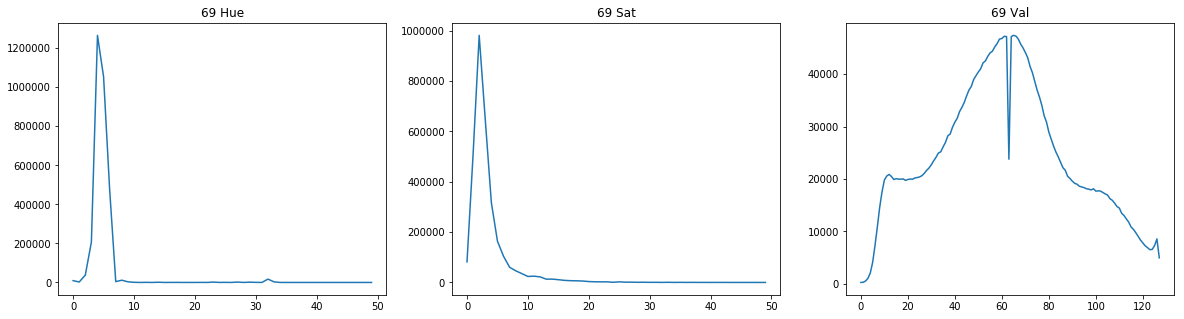

In [55]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

file69_o = "images/ASE_69/69_MS_1_o.JPG"
file70_o = "images/ASE_70/70_MS_1_o.JPG"
file69_r = "images/ASE_69/69_MS_1_r.JPG"
file70_r = "images/ASE_70/70_MS_1_r.JPG"

image69_o = cv2.imread(file69_o)
image70_o = cv2.imread(file70_o)
image69_r = cv2.imread(file69_r)
image70_r = cv2.imread(file70_r)

mask = np.zeros(image69_o.shape[:2], dtype="uint8")
# original images are 2000x2000, so the mask radius will be 1000
(cX, cY) = (image69_o.shape[1] // 2, image69_o.shape[0] // 2)
cv2.circle(mask, (cX, cY), 1000, 255, -1) 

hsv_image = cv2.cvtColor(image70_o, cv2.COLOR_BGR2HSV)

hue, sat, val = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]

hist69_o_h = cv2.calcHist([hue], channels = [0], mask = mask, histSize = [50], ranges=[1, 255])
hist69_o_s = cv2.calcHist([sat], channels = [0], mask = mask, histSize = [50], ranges=[1, 255])
hist69_o_v = cv2.calcHist([val], channels = [0], mask = mask, histSize = [128], ranges=[1, 255])

fg = plt.figure(figsize=(20,5))

fg.add_subplot(131)                             
plt.plot(hist69_o_h)
plt.title('69 Hue')

fg.add_subplot(132)                             
plt.plot(hist69_o_s)
plt.title('69 Sat')

fg.add_subplot(133)                             
plt.plot(hist69_o_v)
plt.title('69 Val')

plt.show()

The 3rd plot shows the brightness. Let's generate the same plots for all the images we have and stack them up together.

In [1]:
import cv2
from matplotlib import pyplot as plt

hist_o_h = {} 
hist_o_s = {} 
hist_o_v = {}

def calcHSVHistograms(image, mask = None, h_hist_size = 50, s_hist_size = 50, v_hist_size = 200):
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    h = cv2.calcHist([hsv_image[:,:,0]], channels = [0], mask = mask, histSize = [h_hist_size], ranges=[1, 255])
    s = cv2.calcHist([hsv_image[:,:,1]], channels = [0], mask = mask, histSize = [s_hist_size], ranges=[1, 255])
    v = cv2.calcHist([hsv_image[:,:,2]], channels = [0], mask = mask, histSize = [v_hist_size], ranges=[1, 255])
    
    return h, s, v

In [ ]:
for i in range(1, 6):
    
    file69_o = "images/ASE_69/69_MS_" + str(i) + "_o.JPG"
    file69_r = "images/ASE_69/69_MS_" + str(i) + "_r.JPG"
    file70_o = "images/ASE_70/70_MS_" + str(i) + "_o.JPG"
    file70_r = "images/ASE_70/70_MS_" + str(i) + "_r.JPG"
    
    img_69_o = cv2.imread(file69_o)
    img_69_r = cv2.imread(file69_r)
    img_70_o = cv2.imread(file70_o)
    img_70_r = cv2.imread(file70_r)
    
    hist_o_h[file69_o], hist_o_s[file69_o], hist_o_v[file69_o] = calcHSVHistograms(img_69_o)
    hist_o_h[file69_r], hist_o_s[file69_r], hist_o_v[file69_r] = calcHSVHistograms(img_69_r)
    hist_o_h[file70_o], hist_o_s[file70_o], hist_o_v[file70_o] = calcHSVHistograms(img_70_o)
    hist_o_h[file70_r], hist_o_s[file70_r], hist_o_v[file70_r] = calcHSVHistograms(img_70_r)

In [ ]:
fig = plt.figure(figsize=(25,10))
for i in range(1, 6):
 
    file69_o = "images/ASE_69/69_MS_" + str(i) + "_o.JPG"
    file69_r = "images/ASE_69/69_MS_" + str(i) + "_r.JPG"
    file70_o = "images/ASE_70/70_MS_" + str(i) + "_o.JPG"
    file70_r = "images/ASE_70/70_MS_" + str(i) + "_r.JPG"
    
    fig.add_subplot(231)
    plt.title('Hue (Obverse)')
    plt.plot(hist_o_h[file69_o], 'g')
    plt.plot(hist_o_h[file70_o], 'b')
    
    fig.add_subplot(232)
    plt.title('Saturation (Obverse)')
    plt.plot(hist_o_s[file69_o], 'g')
    plt.plot(hist_o_s[file70_o], 'b')
    
    fig.add_subplot(233)
    plt.title('Brightness (Obverse)')
    plt.plot(hist_o_v[file69_o], 'g')
    plt.plot(hist_o_v[file70_o], 'b')

    fig.add_subplot(234)
    plt.title('Hue (Reverse)')
    plt.plot(hist_o_h[file69_r], 'g')
    plt.plot(hist_o_h[file70_r], 'b')
    
    fig.add_subplot(235)
    plt.title('Saturation (Reverse)')
    plt.plot(hist_o_s[file69_r], 'g')
    plt.plot(hist_o_s[file70_r], 'b')
    
    fig.add_subplot(236)
    plt.title('Brightness (Reverse)')
    plt.plot(hist_o_v[file69_r], 'g')
    plt.plot(hist_o_v[file70_r], 'b')
    
plt.show()

As expected, the Hue and Saturation values are similar, however the brightness does appear to be higher for grade 70 coins.

### Observations

From the plots above we can observe that 
- The Hue value appears to be higher for grade 70 in the range of 0 to 10
- The Saturation appears to be similar for the both grades
- The Brightness for grade 70 coins is higher in the range of 40 to 80 (obverse only).

### Inference
<p/>
<div style="background-color:#efd469">Even with a limited amout of samples we can observer some solid patterns which can be used for grading automation of ASEs. 

- High histogram values for the grade 70 (RGB space)
- High Hue values for 70s (HSV space)
- High Brightness values for 70s (HSV space) 

This work is by no means conclusive as it is based on few images only. More images need to be analysed for better results. 
</div>

# Other analysis

Additional analysis can be done to track "mechanical" damages i.e. imperfections such as nicks and dents or discoloration. 

## Finding the rust around the edges

The 69_MS_1_r.JPG image has rusty spots around the edges of the coin. 

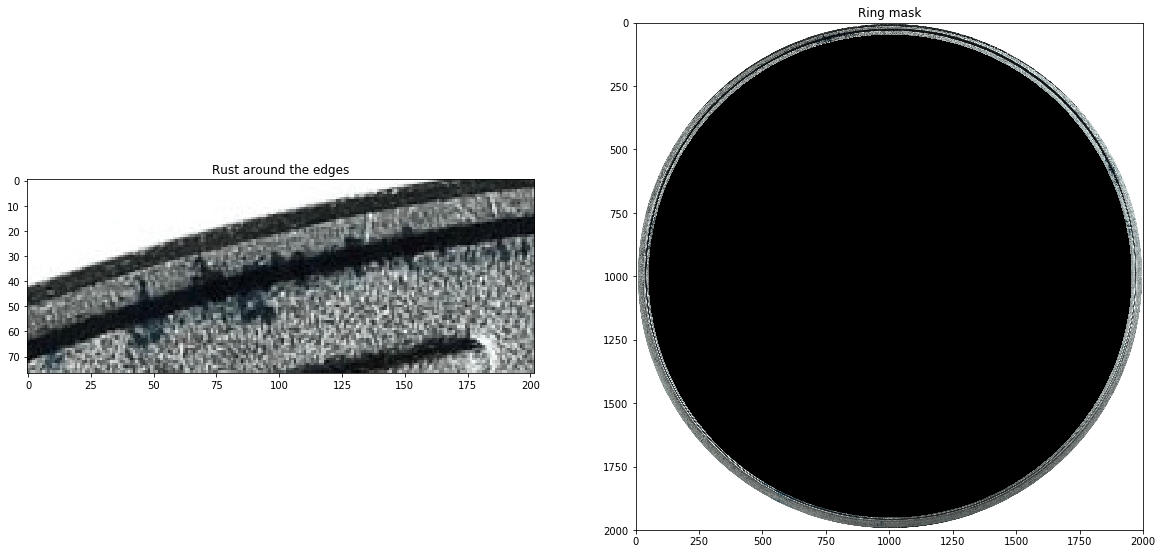

In [45]:
import cv2
from matplotlib import pyplot as plt
import imutils

file69_1_r_rusty_edge = "images/ASE_69/69_MS_1_r_rust.jpg"
file69_1_r_original = "images/ASE_69/69_MS_1_r.JPG"

image_rusty_edge = cv2.imread(file69_1_r_rusty_edge)
image_original = cv2.imread(file69_1_r_original)

image_masked = imutils.apply_ring_mask(image_original, radius_inner = 950, radius_outer = 1000)

fg = plt.figure(figsize=(20, 10))
fg.add_subplot(1,2,1)
plt.title("Rust around the edges")
plt.imshow(image_rusty_edge)

fg.add_subplot(1,2,2)
plt.title("Ring mask")
plt.imshow(image_masked)

plt.show()

Let's generate the histograms for the edges only and separating the rusty from the clean edges.

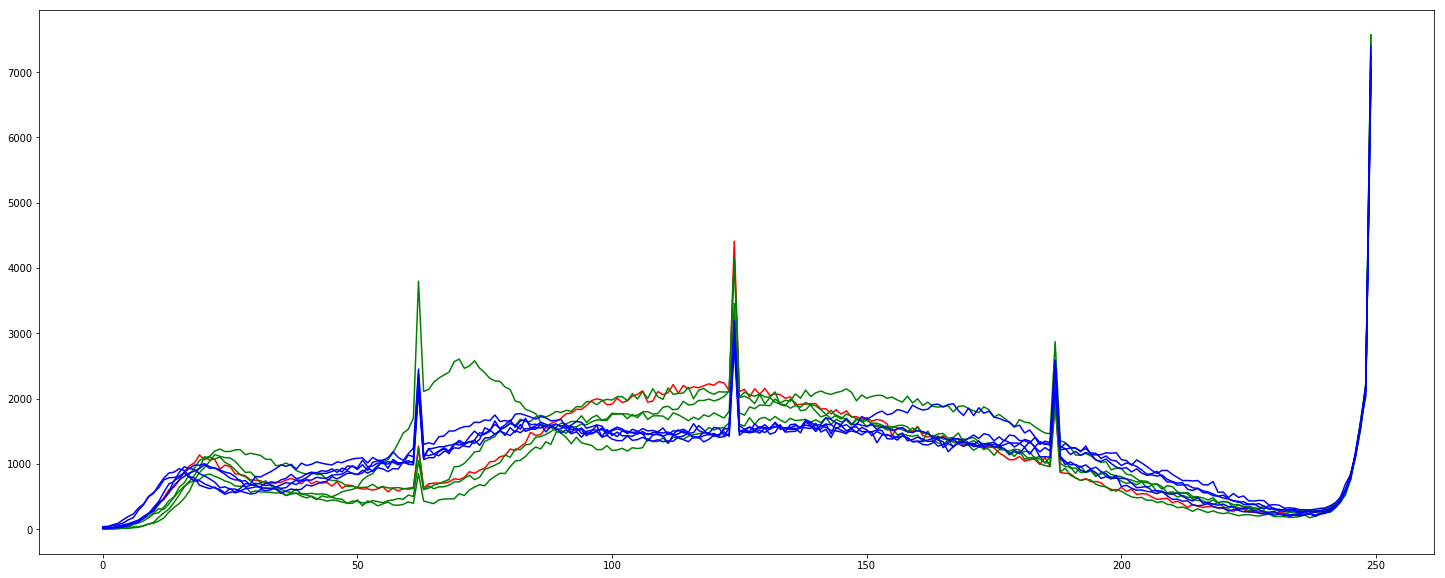

In [51]:
import cv2
from matplotlib import pyplot as plt
import imutils

rusty = ['images/ASE_69/69_MS_1_r.JPG']
clear_69 = ['images/ASE_69/69_MS_2_r.JPG', 'images/ASE_69/69_MS_3_r.JPG', 'images/ASE_69/69_MS_4_r.JPG', 'images/ASE_69/69_MS_5_r.JPG']
clear_70 = ['images/ASE_70/70_MS_1_r.JPG', 'images/ASE_70/70_MS_2_r.JPG', 'images/ASE_70/70_MS_3_r.JPG', 'images/ASE_70/70_MS_4_r.JPG', 'images/ASE_70/70_MS_5_r.JPG']

rusty_hist = {}
clear_hist_69 = {}
clear_hist_70 = {}

for filename in clear_69:
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_masked = imutils.apply_ring_mask(gray, radius_inner = 950, radius_outer = 1000)
    
    hist = cv2.calcHist([gray_masked], channels=[0], mask=None, histSize = [250], ranges=[1, 255])
    clear_hist_69[filename] = hist

for filename in clear_70:
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_masked = imutils.apply_ring_mask(gray, radius_inner = 950, radius_outer = 1000)
    
    hist = cv2.calcHist([gray_masked], channels=[0], mask=None, histSize = [250], ranges=[1, 255])
    clear_hist_70[filename] = hist
    
for filename in rusty:
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_masked = imutils.apply_ring_mask(gray, radius_inner = 950, radius_outer = 1000)
    
    hist = cv2.calcHist([gray_masked], channels=[0], mask=None, histSize = [250], ranges=[1, 255])
    rusty_hist[filename] = hist

f1 = plt.figure(figsize=(25, 10))    
f1.add_subplot(1,1,1)    
for key in rusty_hist:
    plt.plot(rusty_hist[key], 'r')

for key in clear_hist_69:
    plt.plot(clear_hist_69[key], 'g')

for key in clear_hist_70:
    plt.plot(clear_hist_70[key], 'b')
    
plt.show()

### Observation
As expected, the rusty colors should manifest in the mid range (100 to 150) where we can clearly see that the coin with the rusty edges has the highest peak value (red), followed by other 69s (green) and finally followed by 70s having the lowest values in the given range.

## Proposed model (draft ideas)

While we are far from completing all analysis, at this point we can say that the final model for grading automation should consist of a set of filters, each responsible for a particular type of processing. Each filter will be assigned a particular weight signifying the importance of the "imperfection" it is designed to identify. The final score will be assigned based on the weighted sum of all returns (_possibly with softmaxing should we decide to measure the returned values in confidence levels_)

* don't forget camera-based calibration 
* consider using near-perfect MS coin image to be used as "reference point", calculating the final score as a "distance" from the reference point.